In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

# import mpld3
# mpld3.enable_notebook()


vpi = 1
n_test = 30
start_date_idx = 2

data = pd.read_csv("./data/production_series_"+str(vpi)+".csv")

open_dates = ['2011-08-22', '2012-03-19', '2012-10-17', '2013-10-10', 
              '2014-03-09', '2014-06-13', '2016-10-31']

mask = (data["Date"] >= open_dates[start_date_idx]) & (data["Date"] < open_dates[start_date_idx+1])
data = data.loc[mask]

data['date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d")
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['dayofyear'] = data['date'].dt.dayofyear
data['weekday'] = data['date'].dt.weekday
data['dayofmonth'] = data['date'].dt.day
# data['quarter'] = data['date'].dt.quarter
# data['maintain'] = np.where(data.Oil_rate == 0, 1, 0)

lags = [31, 38, 45, 52, 59]
for lag in lags:
    data['lag_'+str(lag)] = data.Oil_rate.shift(lag)

data['diff'] = data['THP'] - data['BHP_NEW']

data = data.fillna(0)

data_date = data.Date.values

data.tail()

,Date,WellId,Oil_rate,Gas_rate,Water_rate,THP,BHP_NEW,GASLIFT,date,year,month,dayofyear,weekday,dayofmonth,lag_31,lag_38,lag_45,lag_52,lag_59,diff
775,2013-10-05,VPI-01,1938.81,1734.020600,2554.67,460.0,2548.0,1470.0,2013-10-05,2013,10,278,5,5,2996.79,3010.77,2825.79,2770.07,0.00,-2088.0
776,2013-10-06,VPI-01,3460.39,3137.083950,4486.74,507.0,2564.0,1100.0,2013-10-06,2013,10,279,6,6,3121.79,3065.05,2866.50,2605.32,3317.41,-2057.0
777,2013-10-07,VPI-01,3303.86,3011.740199,4661.79,498.0,2557.0,1120.0,2013-10-07,2013,10,280,0,7,3127.14,3116.80,2913.07,2422.28,3234.08,-2059.0
778,2013-10-08,VPI-01,3209.42,2916.260026,4607.11,490.0,2558.0,1090.0,2013-10-08,2013,10,281,1,8,3115.33,3199.80,3068.32,2387.28,2656.64,-2068.0
779,2013-10-09,VPI-01,3341.85,2959.357070,4528.77,493.0,2555.0,1000.0,2013-10-09,2013,10,282,2,9,2861.67,3165.53,2921.18,2730.51,2016.54,-2062.0


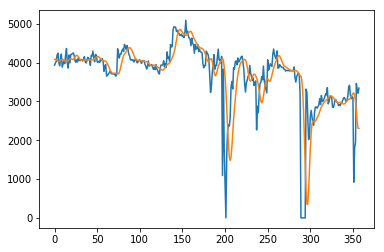

In [2]:
# https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

sns.lineplot(range(len(data.Oil_rate.values)), data.Oil_rate.values)
smooth_oil = smooth(data.Oil_rate.values)
smooth_oil =smooth_oil[:len(data.Oil_rate.values)]
sns.lineplot(range(len(smooth_oil)), smooth_oil )

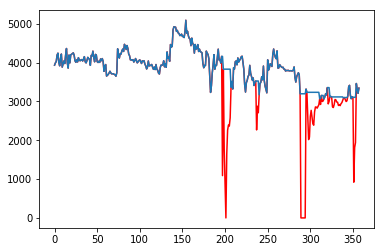

In [3]:
#detect outlier and replace them
def z_score_outlier(ys):
    mean = np.mean(ys)
    std = np.std(ys)
    z_scores = [(y-mean)/std for y in ys]
    return np.where(np.abs(z_scores) > 3)

def iqr_outlier(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - 0.5*iqr
    upper_bound = quartile_3 + 1.5*iqr
    return np.where((ys < lower_bound) | (ys > upper_bound))[0]

#trace original oil rates
first_oil_rate = data.Oil_rate.values

sns.lineplot(range(len(first_oil_rate)), first_oil_rate, color="red")

#set outliers to be changepoints
oil_rate_idx = data.columns.get_loc('Oil_rate')
data.iloc[iqr_outlier(data.Oil_rate.values), oil_rate_idx] = 0

#remove changepoints
for i in range(len(data)):
    if data.iloc[i, oil_rate_idx]==0:
        data.iloc[i, oil_rate_idx] = data.iloc[i-1, oil_rate_idx]
            
sns.lineplot(range(len(data.Oil_rate.values)), data.Oil_rate.values)

In [ ]:
# mean group by year and month 
group_mean = pd.pivot_table(data, index='year', columns='month', values='Oil_rate', 
    aggfunc=np.mean).reset_index('year')
start_year = datetime.strptime(data_date[0], '%Y-%m-%d').year
end_year = datetime.strptime(data_date[-1], '%Y-%m-%d').year
for i in range(start_year, end_year):
    line = group_mean[group_mean.year==i].values[0][1:]
    sns.lineplot(list(set(data.month.values)),line)
plt.legend('12345')

In [ ]:
# mean group by year and month
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(121)
group_weekday_month= pd.pivot_table(data, index='weekday', columns='month', values='Oil_rate', aggfunc=np.mean).reset_index('weekday')
for i in range(0, 7):
    line = group_weekday_month[group_weekday_month.weekday==i].values[0][1:]
    sns.lineplot(list(set(data.month.values)),line, ax=ax1)
plt.legend('0123456')

ax2 = fig.add_subplot(122)
group_weekday_year = pd.pivot_table(data, index='weekday', columns='year', values='Oil_rate', aggfunc=np.mean).reset_index('weekday')
for i in range(0, 7):
    line = group_weekday_year[group_weekday_year.weekday==i].values[0][1:]
    sns.lineplot(list(set(data.year.values)),line, ax=ax2)
plt.legend('0123456')

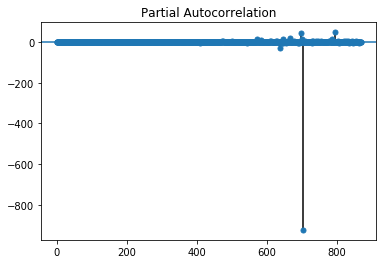

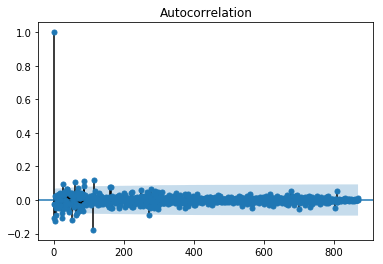

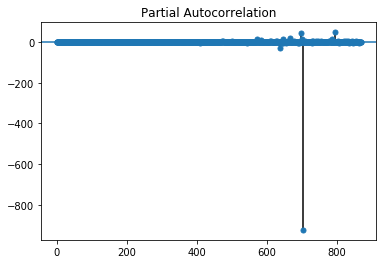

In [4]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
%matplotlib inline

diff = data.Oil_rate.shift(1)
diff = diff.fillna(0)
diff = diff - data.Oil_rate
diff.values.tolist()
plot_acf(diff.values.tolist())
plot_pacf(diff.values.tolist())
# plot_pacf(data.diff.values.tolist())

In [4]:
#'THP', 'BHP_NEW', 'GASLIFT' are not really crucial features
avoid_cols = ['Date', 'WellId', 'Gas_rate', 'Water_rate', 'date', 'year', 'THP', 'BHP_NEW', 'GASLIFT']
cols = [col for col in data.columns if col not in avoid_cols]
data = data.loc[:, cols]

In [5]:
# Using step_predict for small lags, eg: 1, 2, 3, 4, 5
def step_predict(model, train, test, lags):
    df = pd.concat([train, test])
    n_train = len(train)
    n_test = len(test)
    
    preds = []
    for i in range(n_train,n_train+n_test):
        pred = model.predict(df.iloc[i, 1:])
        df.iloc[i, 0] = pred
        preds.append(pred[0])
        
        #update lag after each round of prediction
        for j in range(i+1,n_train+n_test):
            for lag in lags:
                lag_idx = df.columns.get_loc('lag_'+str(lag))
                df.iloc[j, lag_idx] = df.iloc[j-lag, 0]
    return preds


In [6]:
import xgboost as xgb
from statsmodels.tsa.arima_model import ARIMA

step_preds = {'xgb': {}, 'arima': {}}

for step in range(90, len(data), n_test):

    train = data.iloc[step-90:step]
    test = data.iloc[step:step+n_test]

    x_train, y_train = train.iloc[:, 1:].as_matrix(), train.iloc[:, 0]
    x_test, y_test = test.iloc[:, 1:].as_matrix(), test.iloc[:, 0]
    
    y_train = np.log1p(y_train)

    #xgb model
    xgb_model = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.5, learning_rate = 0.1,
        max_depth = 5, alpha = 10, n_estimators = 100)

    xgb_model.fit(x_train, y_train)

    preds = xgb_model.predict(x_test)
    #preds = step_predict(xgb_model, train, test, lags)
    preds = np.exp(preds)-1

    #smooth the predictions of xgb model
    window_smooth = 11
    if len(preds)> window_smooth:
        step_preds['xgb'][step] = smooth(preds)[:len(preds)]
    else:
        step_preds['xgb'][step] = preds

    #arima model
    y_train = data.iloc[0:step, 0]
    arima_model = ARIMA(y_train, order=(2, 1, 0))
    arima_model = arima_model.fit(disp=0)

    preds = arima_model.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, typ="levels")
    step_preds['arima'][step] = preds.values.tolist()
    
    #get importance of features
    df = pd.DataFrame({'cols':train.columns.values[1:], 'importance':xgb_model.feature_importances_})
    print(df)


         cols  importance
0       month    0.066038
1   dayofyear    0.287062
2     weekday    0.134771
3  dayofmonth    0.137466
4      lag_31    0.080863
5      lag_38    0.061995
6      lag_45    0.071429
7      lag_52    0.040431
8      lag_59    0.033693
9        diff    0.086253
         cols  importance
0       month    0.037086
1   dayofyear    0.237086
2     weekday    0.083444
3  dayofmonth    0.083444
4      lag_31    0.098013
5      lag_38    0.111258
6      lag_45    0.121854
7      lag_52    0.080795
8      lag_59    0.066225
9        diff    0.080795
         cols  importance
0       month    0.053254
1   dayofyear    0.237870
2     weekday    0.060355
3  dayofmonth    0.089941
4      lag_31    0.069822
5      lag_38    0.138462
6      lag_45    0.123077
7      lag_52    0.087574
8      lag_59    0.066272
9        diff    0.073373
         cols  importance
0       month    0.027237
1   dayofyear    0.180285
2     weekday    0.085603
3  dayofmonth    0.085603
4      lag_3

In [7]:
# calculate rmse by using predictions and the smooth values of original rates
# because we are focusing on trends
from sklearn.metrics import mean_squared_error

rmse = {'arima':[], 'xgb': []}

smooth_oil_rate = smooth(data.Oil_rate.values)[:len(data.Oil_rate.values)]

for step in range(90, len(data), n_test):
    y_test = smooth_oil_rate[step:step+n_test]
    for model in rmse.keys():
        rmse[model].append(np.sqrt(mean_squared_error(y_test, step_preds[model][step][0:len(y_test)])))
    
print('RMSE: ')
for model in rmse.keys():
    print(model, np.array(rmse[model]).mean())
    

RMSE: 
arima 289.5725543659825
xgb 259.76389909773087


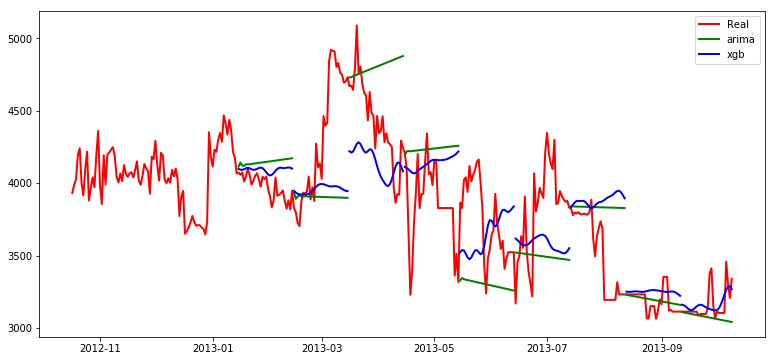

In [8]:
from collections import OrderedDict
def generate_x_axis(start_date, n_test=30):
    return pd.date_range(start_date, periods=n_test, freq='D')

fig = plt.figure(figsize=(13,6))
sns.lineplot(generate_x_axis(data_date[0], len(first_oil_rate)), first_oil_rate, color="red", label="Real", linewidth=2)

colors = {'arima': 'green', 'xgb': 'blue'}

for model in step_preds.keys():
    for key in step_preds[model].keys():
        sns.lineplot(generate_x_axis(data_date[key], len(step_preds[model][key])), step_preds[model][key], color=colors[model], label=model, linewidth=2)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))

plt.legend(by_label.values(), by_label.keys(), loc="upper right")